# Difc calculation using scipy


In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [4]:
%%time
ws = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

CPU times: user 55.8 s, sys: 2min, total: 2min 55s
Wall time: 5min 23s


In [5]:
%%time
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

CPU times: user 3min 37s, sys: 3min 2s, total: 6min 40s
Wall time: 27.4 s


## Compute nominal difc

In [6]:
difc = msa.CalculateDIFC(InputWorkspace=ws)

In [7]:
difc = difc.extractY().flatten()

# Use nominal values to convert to I(d)

In [8]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

CPU times: user 11.5 s, sys: 10.7 s, total: 22.2 s
Wall time: 22.2 s


In [9]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.005,7')

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


# Get pack index

In [10]:
instrument = ws.getInstrument()

In [11]:
pack = instrument.getComponentByName("B3/eightpack")

In [12]:
firstpixel = pack[0][0].getID()
firstpixel

39936

In [13]:
lasttube = pack[pack.nelements()-1]
lastpixel = lasttube[lasttube.nelements()-1]
lastpixel = lastpixel.getID()
lastpixel

40959

In [14]:
detIDs = []
for i in range(ws.getNumberHistograms()):
    sp = ws.getSpectrum(i)
    dets = list(sp.getDetectorIDs())
    assert len(dets)==1
    detIDs.append(dets[0])
    continue

In [15]:
for i in range(len(detIDs)-1):
    assert detIDs[i] < detIDs[i+1]

In [16]:
startindex = detIDs.index(firstpixel)
endindex = detIDs.index(lastpixel)
startindex, endindex

(2048, 3071)

In [17]:
I_d_B3 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=startindex, EndWorkspaceIndex=endindex)

<IPython.core.display.Javascript object>


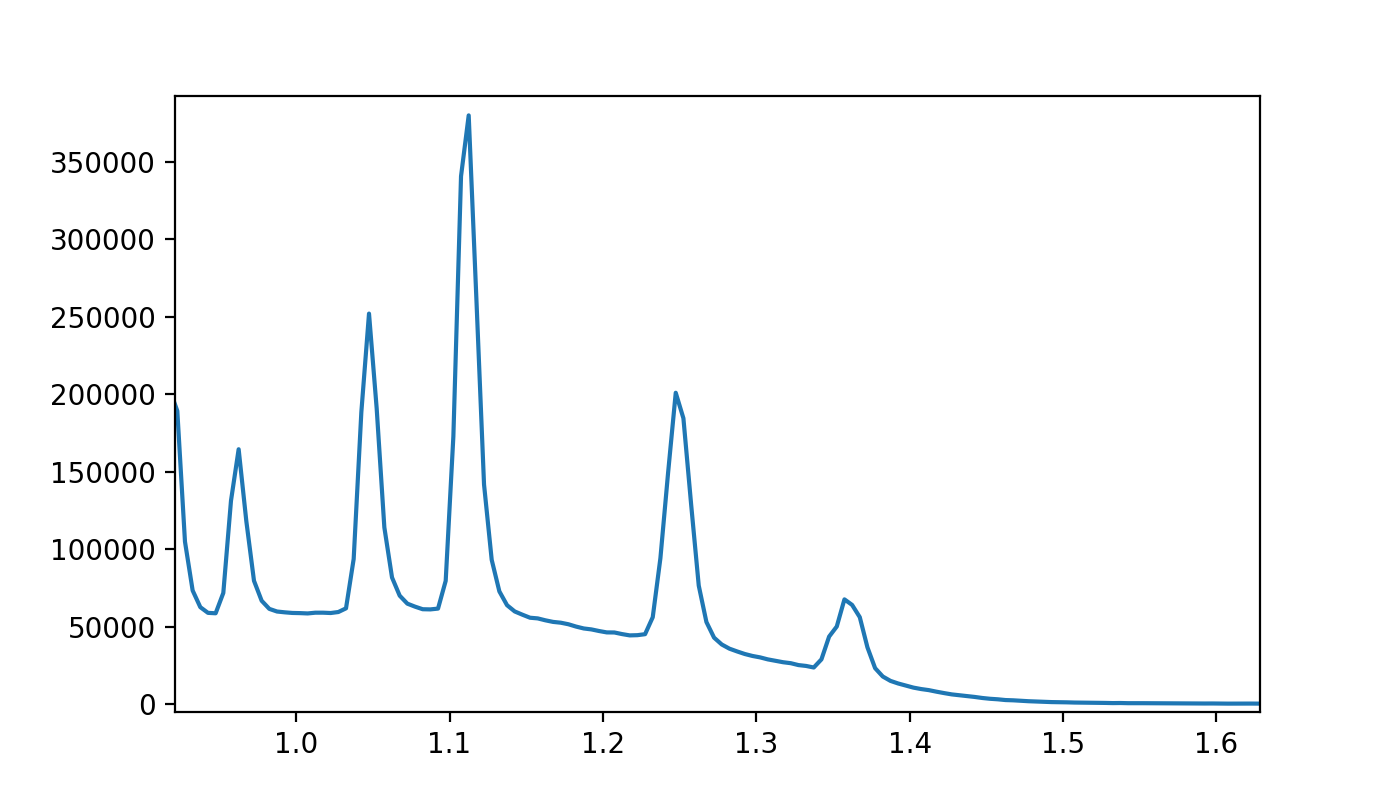

(0, 3.8)

In [20]:
plt.figure(figsize=(7,4))
Xbb = I_d_B3.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_B3.readY(0))
plt.xlim(0,3.8)

In [38]:
startindex+60startindex+60

2108

In [21]:
I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=startindex+60, EndWorkspaceIndex=startindex+60)

<IPython.core.display.Javascript object>


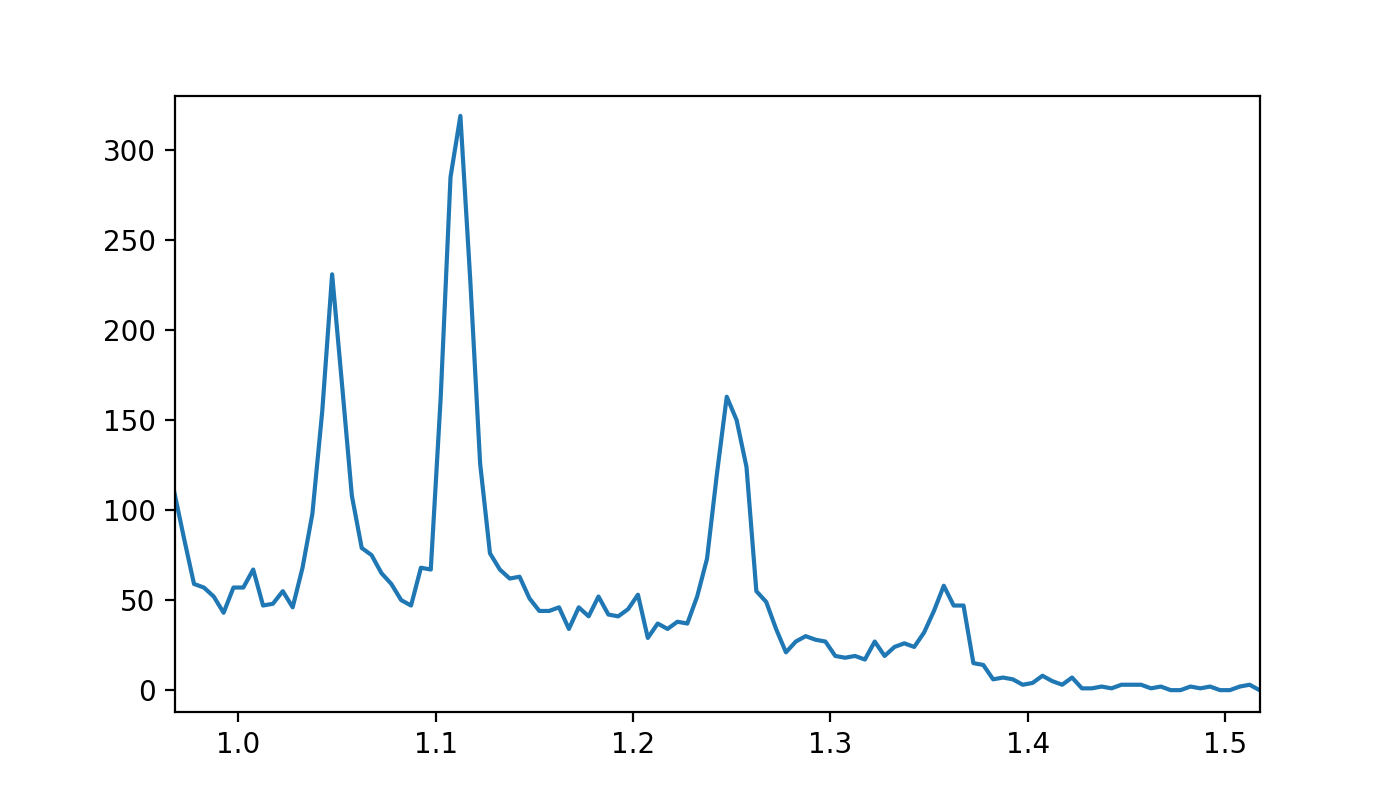

(0, 3.8)

In [80]:
plt.figure(figsize=(7,4))
Xbb = I_d_pixel.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_pixel.readY(0))
plt.xlim(0,3.8)

Simple fitting

In [23]:
import scipy.optimize as sopt

In [24]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [25]:
def gauss_with_bg(x, *p):
    A, mu, sigma, bg = p
    return bg + A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [26]:
x = (Xbb[:-1]+Xbb[1:])/2
y = I_d_pixel.readY(0)

In [30]:
np.where(x>1.2)[0][0], np.where(x<1.3)[0][-1]

(160, 179)

In [31]:
x1 = x[160:179]
y1 = y[160:179]

<IPython.core.display.Javascript object>


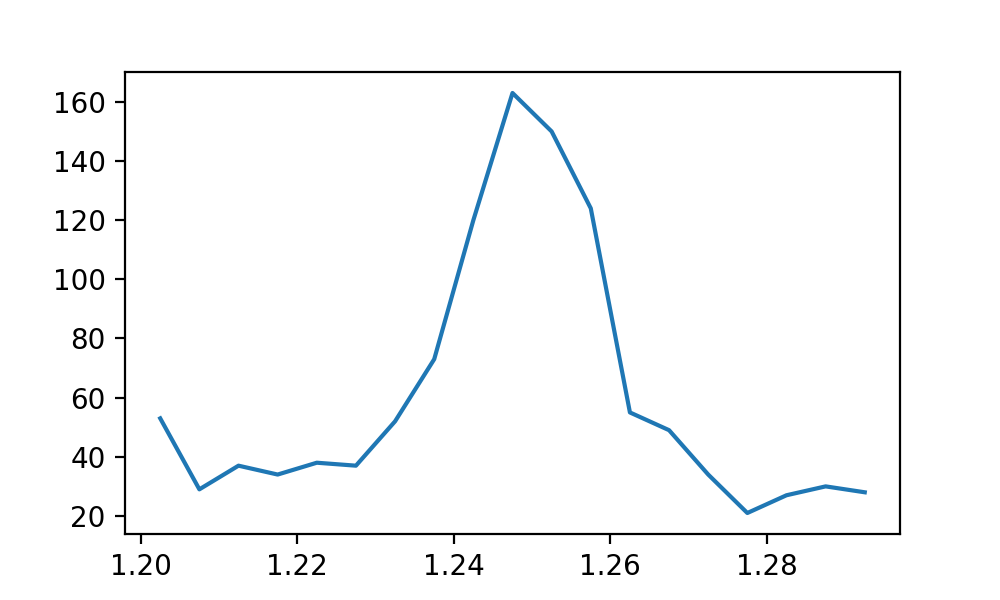

In [32]:
plt.figure(figsize=(5,3))
plt.plot(x1,y1)

In [34]:
popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=(160, 1.25, 0.01, 20))
print popt

[  1.31365605e+02   1.24954773e+00   7.91911155e-03   3.32879729e+01]


<IPython.core.display.Javascript object>


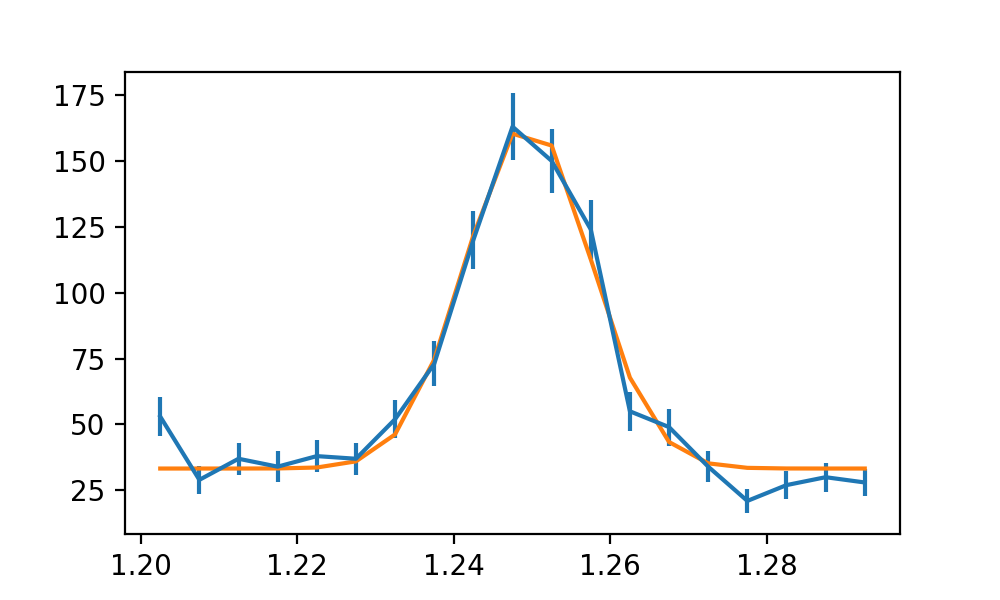

In [35]:
plt.figure(figsize=(5,3))
plt.errorbar(x1, y1, yerr=np.sqrt(y1))
plt.plot(x1, gauss_with_bg(x1, *popt))

goodness of fit?

In [36]:
chisq = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)

In [37]:
chisq

1.3091894095802923

In [39]:
difc[2108]

6036.2127662669545

new difc

In [41]:
difc[2108]*popt[1]/1.24596143

6053.5870159772376

## Loop over all pixels in D23

In [42]:
N = I_d.getNumberHistograms()

In [82]:
maxchisq = 3.
min_counts = 200 # at least this many counts per peak

In [95]:
newdifc = difc.copy()

In [92]:
mask = np.zeros(difc.shape, dtype=bool)
chisq = np.zeros((len(dvalues),) + difc.shape, dtype=float)
peaks = np.zeros((len(dvalues),) + difc.shape, dtype=float)

In [75]:
firstindex, lastindex = startindex, endindex

In [96]:
%%time

for pixel in range(firstindex, lastindex+1):
# for pixel in range(firstindex+0, firstindex+1):
    if (pixel%100)==0 : print pixel
    # print pixel
    I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=pixel, EndWorkspaceIndex=pixel)
    Xbb = I_d_pixel.readX(0)
    x = (Xbb[:-1]+Xbb[1:])/2
    y = I_d_pixel.readY(0)
    peaks_thispixel = peaks[:, pixel]
    for pkindex, d0 in enumerate(dvalues):
        dmin = d0*.96
        dmax = d0*1.04
        startindex, stopindex = np.where(x>dmin)[0][0], np.where(x<dmax)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        if np.sum(y1) < min_counts:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print x1
        # print y1
        guess_center = x1[np.argmax(y1)]
        startindex, stopindex = np.where(x>guess_center-0.05*d0)[0][0], np.where(x<guess_center+0.05*d0)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        bg = (y1[0]+y1[-1])/2
        p0 = np.max(y1)-bg, guess_center, 0.01, bg
        # print "p0=",p0
        # print x1
        # print y1
        try:
            popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
        except:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print "popt=", popt
        chisq1 = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)
        chisq[pkindex, pixel] = chisq1
        # print "chisq=", chisq1
        if chisq1 > maxchisq:
            peaks_thispixel[pkindex] = np.nan
            continue
        peaks_thispixel[pkindex] = popt[1]
        continue
    Ngoodfit = np.sum(np.isfinite(peaks_thispixel))
    # print Ngoodfit
    if not Ngoodfit:
        mask[pixel] = 1
        continue
    ratios = peaks_thispixel / dvalues
    # print "ratios=", ratios
    good_ratios = ratios[np.isfinite(ratios)]
    # print "good_ratios=", good_ratios
    average_ratio = np.average(good_ratios)
    newdifc[pixel] = difc[pixel] * average_ratio
    # print average_ratio
    # break
    continue

/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide


2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
CPU times: user 22.2 s, sys: 3.46 s, total: 25.7 s
Wall time: 20.7 s


In [97]:
tube=2
tube_slice = slice(firstindex+128*tube, firstindex+128*(tube+1))
newdifc[tube_slice]/difc[tube_slice]

array([ 1.        ,  1.        ,  1.00281898,  1.00388206,  1.00350481,
        1.00391458,  1.00397037,  1.0039225 ,  1.00386316,  1.00377171,
        1.00374972,  1.00415542,  1.00381193,  1.00286692,  1.00307414,
        1.00351601,  1.00324435,  0.99896166,  1.00351972,  1.00354582,
        1.0034095 ,  1.00387235,  1.003091  ,  1.00281414,  1.00350423,
        1.00381723,  1.00351623,  1.00330066,  1.00383435,  1.00298643,
        1.00340138,  1.00323293,  1.00326602,  1.00352398,  1.00292504,
        1.00337718,  1.00305061,  1.00321509,  1.0032575 ,  1.00240126,
        1.00275055,  1.00262064,  1.0030622 ,  1.00262416,  1.00239561,
        1.00254109,  1.00250518,  1.00221758,  1.00257562,  1.00254592,
        1.00229366,  1.00275312,  1.00266977,  1.00192233,  1.00218526,
        1.0026095 ,  1.00234947,  1.00254933,  1.00212434,  1.0019212 ,
        1.0020471 ,  1.00223025,  1.00206571,  1.00208524,  1.00211694,
        1.00189813,  1.00184969,  1.00169955,  1.0018889 ,  1.00

In [98]:
newdifc[2108]

6052.7015104826314

# Check aligned I(d)

In [51]:
t = msa.Load('./difc_cal.nxs')

In [52]:
t.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [53]:
tzero = np.array(t.column('tzero'))

In [54]:
np.all(tzero==0)

True

In [99]:
for i, v in enumerate(newdifc):
    t.setCell('difc', i, v)
    continue

In [100]:
%%time
aligned = msa.AlignDetectors(InputWorkspace=ws, CalibrationWorkspace=t)

CPU times: user 36.7 s, sys: 39.4 s, total: 1min 16s
Wall time: 55.1 s


In [57]:
%%time
aligned = msa.CropWorkspace(InputWorkspace='aligned', XMin=0.4, XMax=7)

CPU times: user 42.7 s, sys: 1min 2s, total: 1min 45s
Wall time: 22 s


In [101]:
%%time
I_d_aligned = msa.Rebin(InputWorkspace=aligned, Params='0.4,0.0005,7')

CPU times: user 7.61 s, sys: 26.5 s, total: 34.1 s
Wall time: 45.3 s


In [102]:
I_d_pack_B3 = msa.SumSpectra(InputWorkspace=I_d_aligned, StartWorkspaceIndex=startindex, EndWorkspaceIndex=endindex)

<IPython.core.display.Javascript object>


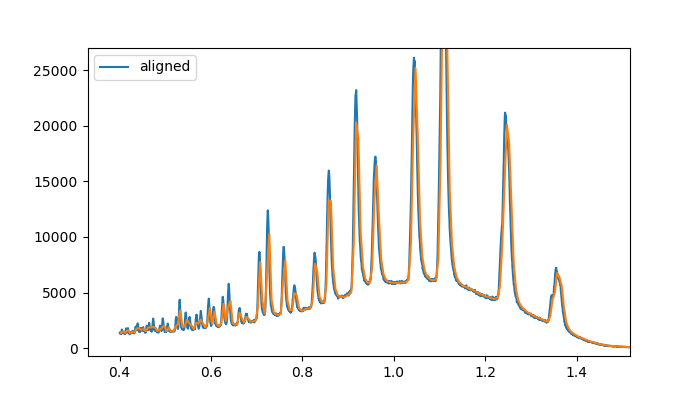

In [103]:
x_bb = I_d_pack_B3.readX(0); y = I_d_pack_B3.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2
plt.figure(figsize=(7,4))
plt.plot(x,y, label='aligned')
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_B3.readY(0)/10)
# plt.xlim(3,3.3)
plt.legend(loc='upper left')

In [104]:
np.sum(mask[firstindex:lastindex+1])

80